### Simple 2D exampling of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from diffusion import (
    get_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_2d,
)
from util import (
    get_torch_size_string,
    plot_ddpm_2d_result,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
device = 'mps' # mps, cpu
print ("device:[%s]"%(device))

device:[mps]


### Training data `x_0`: [N x C x W x H]

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
x_0 = train_data[:,None,:,:].to(device)/255.
print ("MNIST ready. train_data:[%s]"%(get_torch_size_string(x_0)))

MNIST ready. train_data:[60000x1x28x28]


### Train 

it:[      0][0.0]% loss:[0.7344]


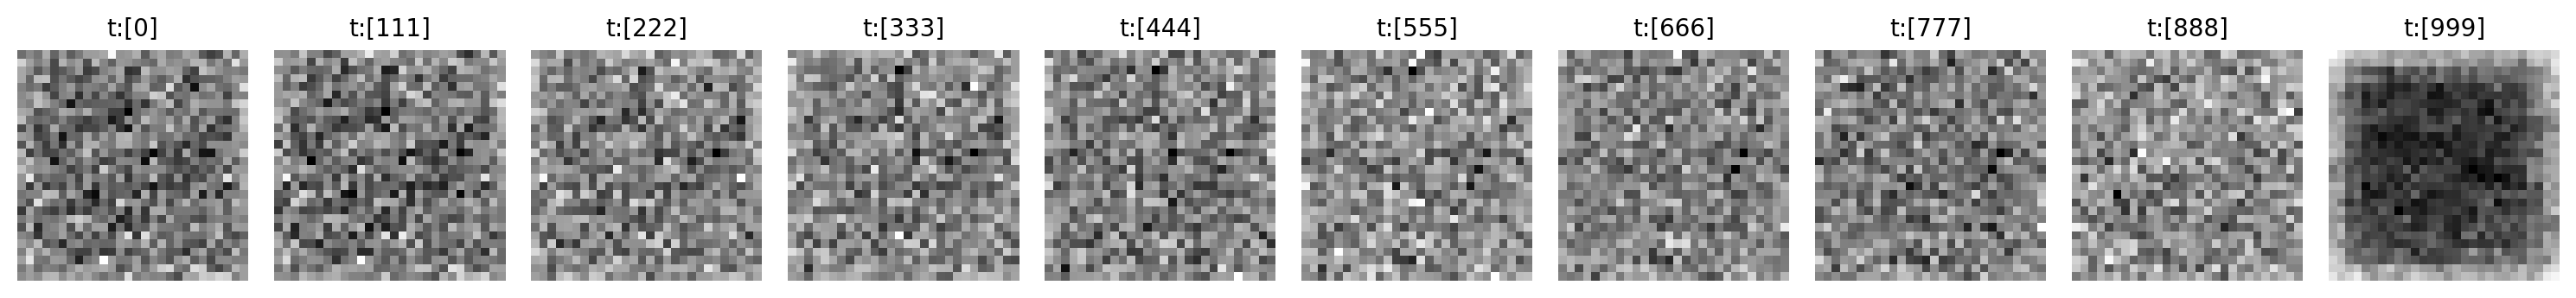

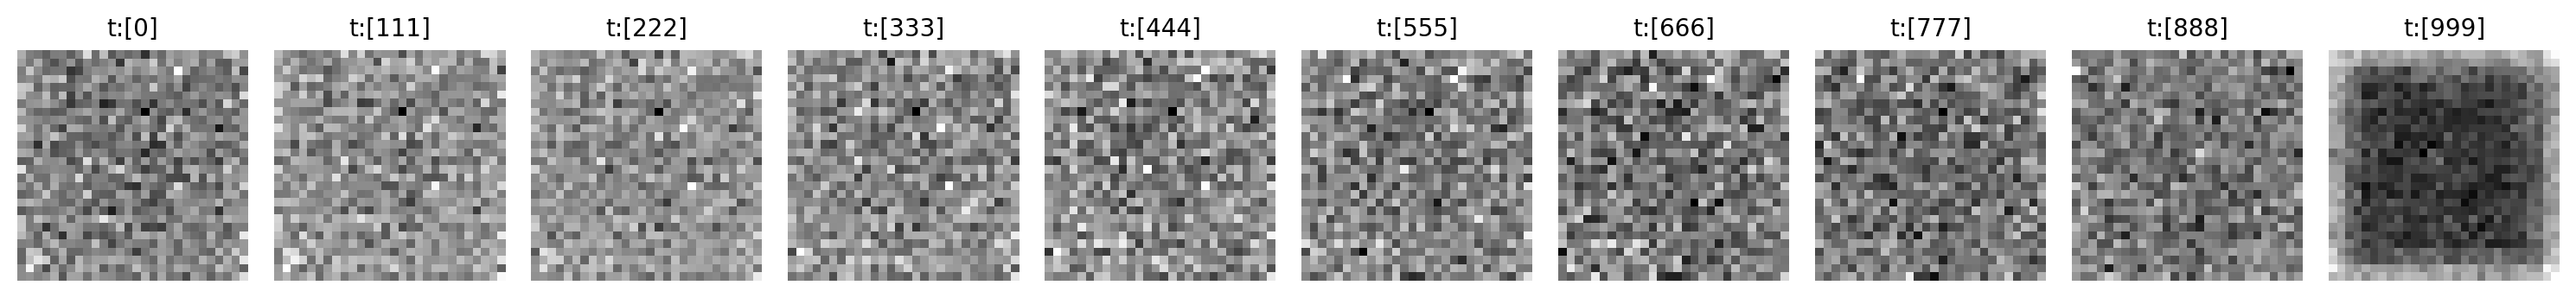

it:[   1000][10.0]% loss:[0.1144]
it:[   2000][20.0]% loss:[0.1051]


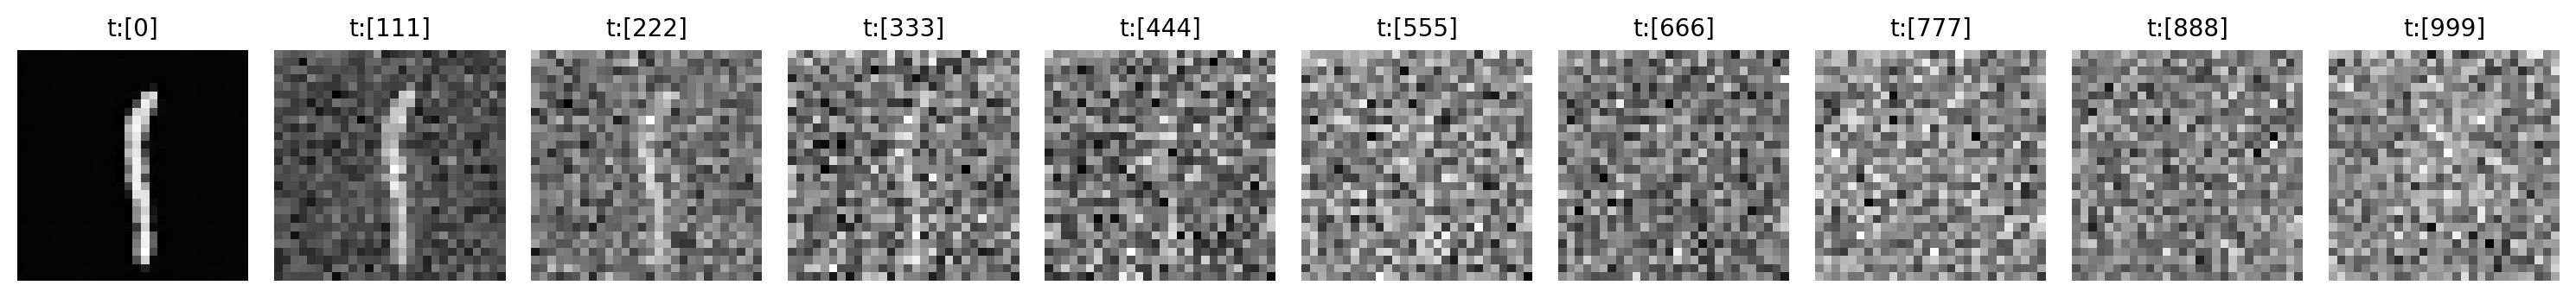

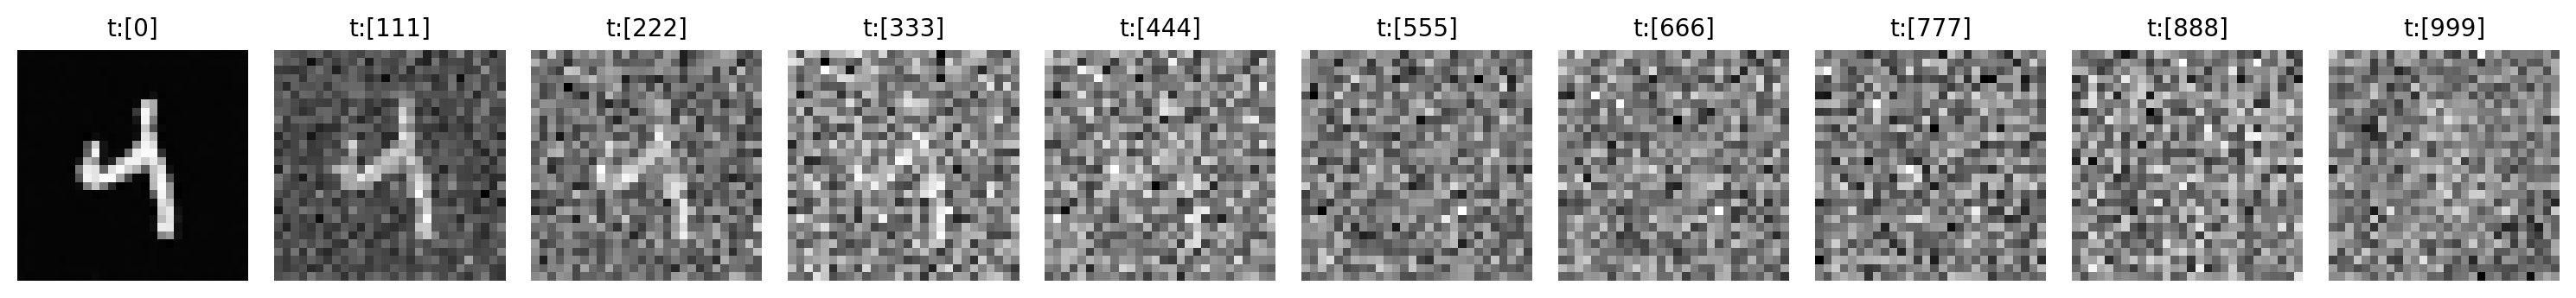

it:[   3000][30.0]% loss:[0.0799]
it:[   4000][40.0]% loss:[0.0778]


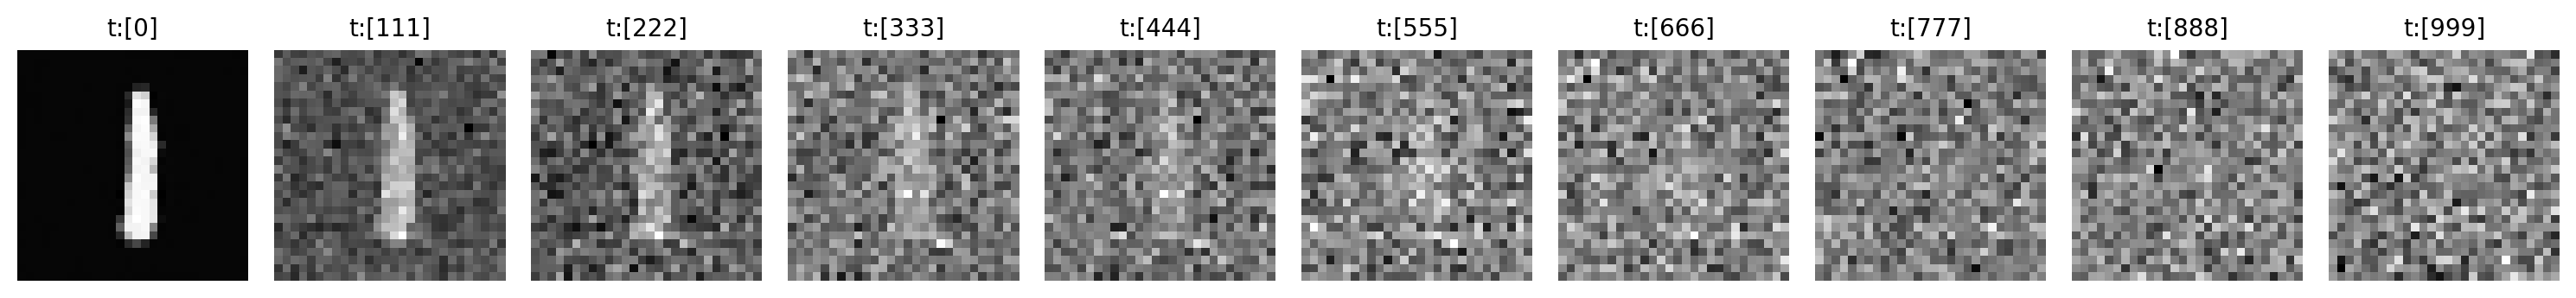

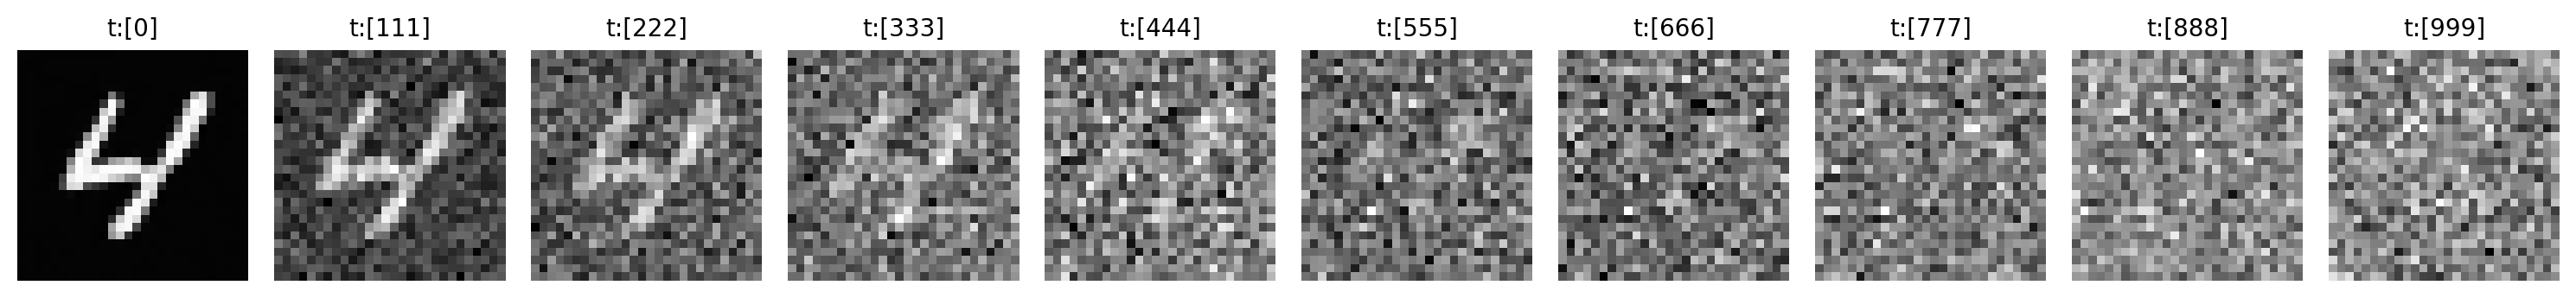

it:[   5000][50.0]% loss:[0.0718]
it:[   6000][60.0]% loss:[0.0666]


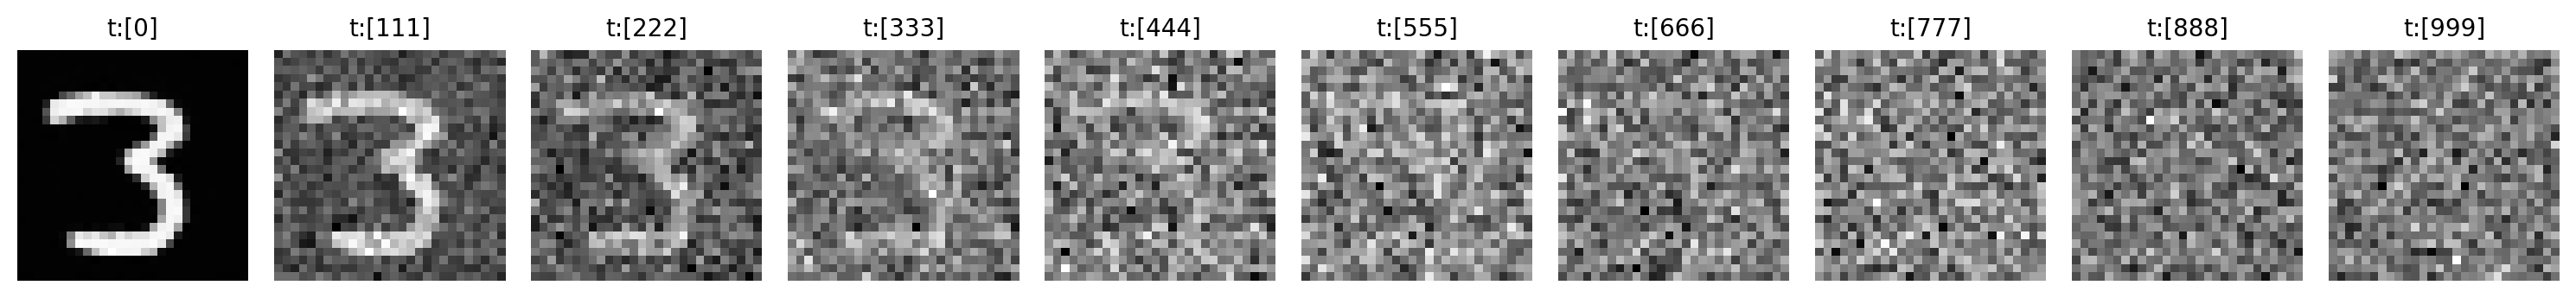

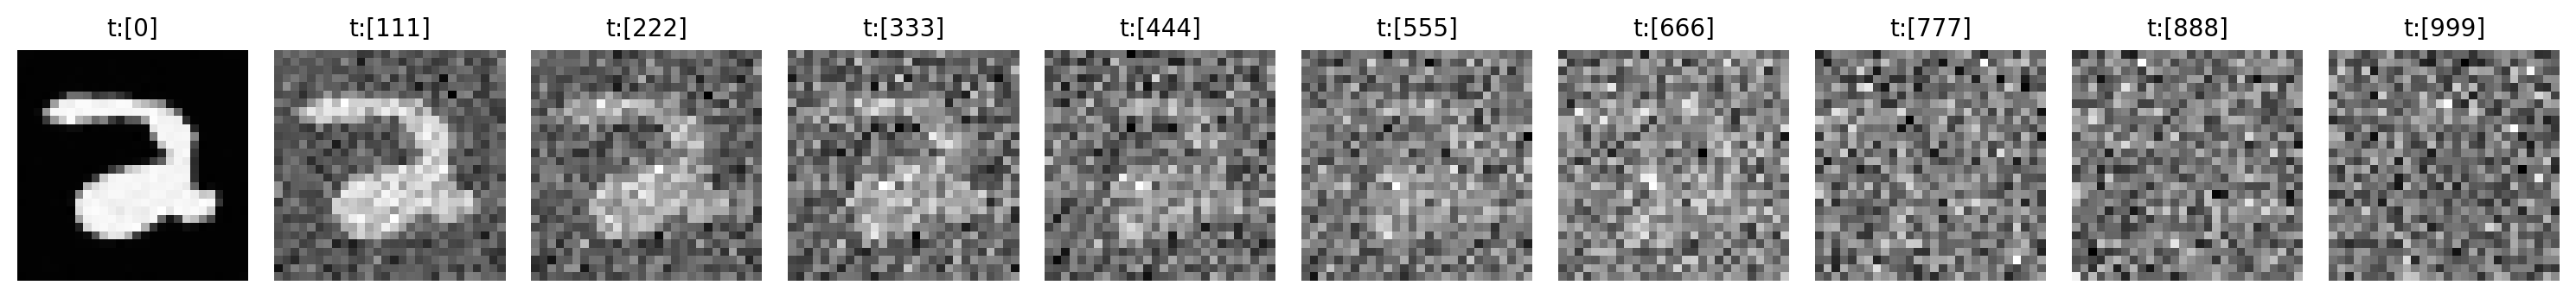

it:[   7000][70.0]% loss:[0.0591]
it:[   8000][80.0]% loss:[0.0783]


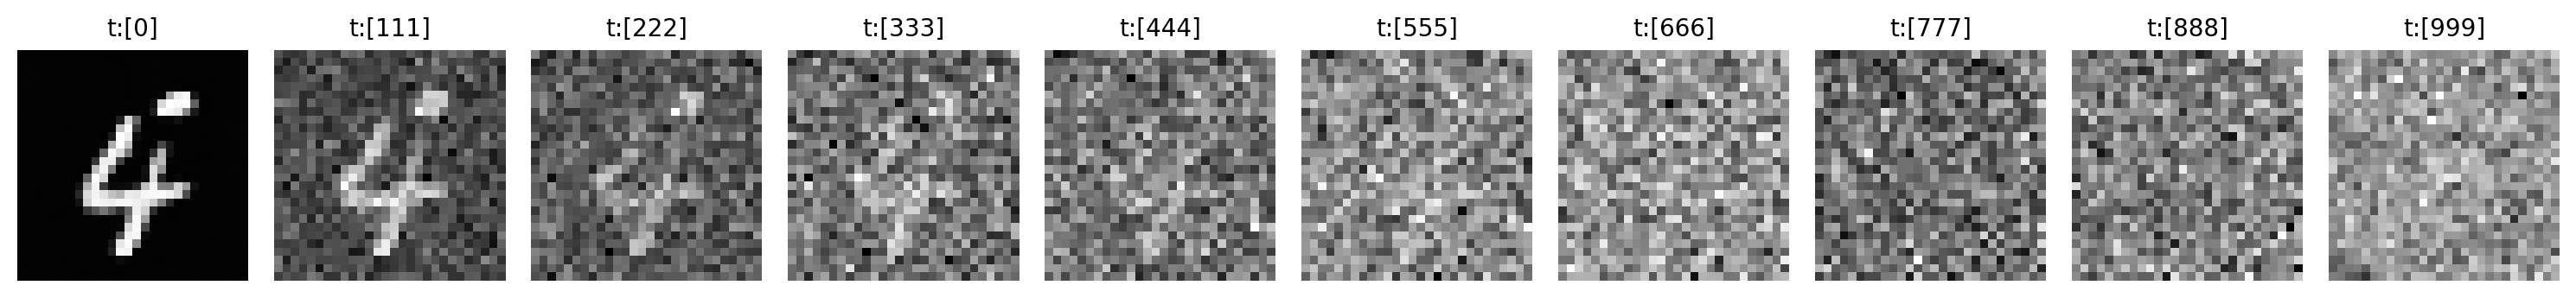

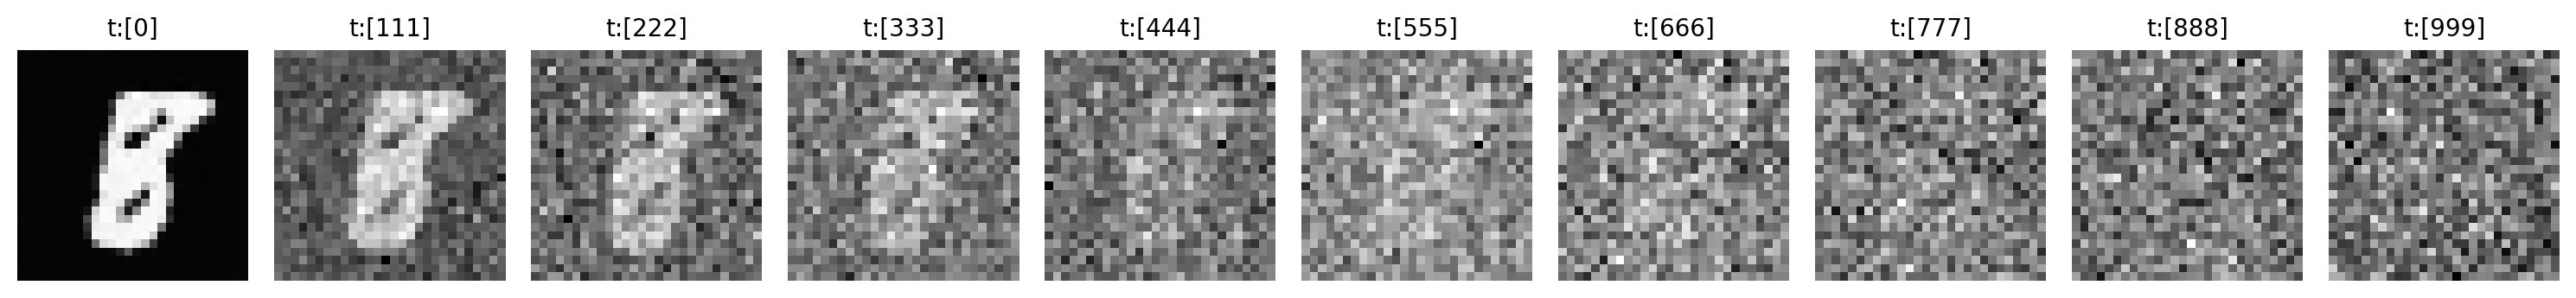

it:[   9000][90.0]% loss:[0.0842]
it:[   9999][100.0]% loss:[0.0701]


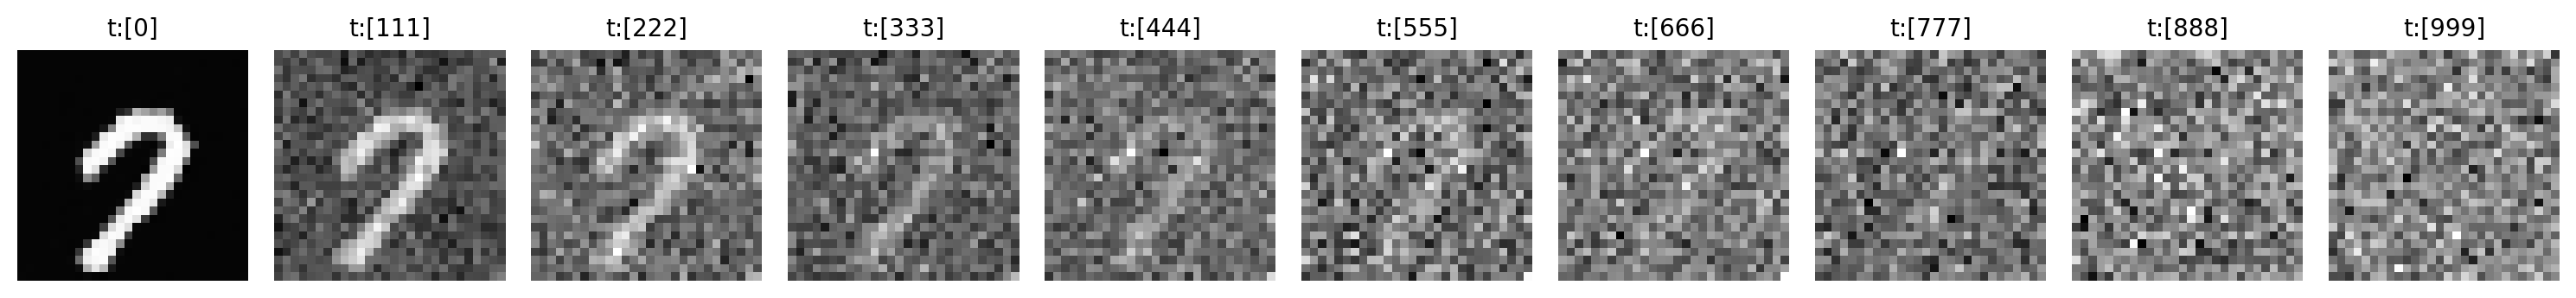

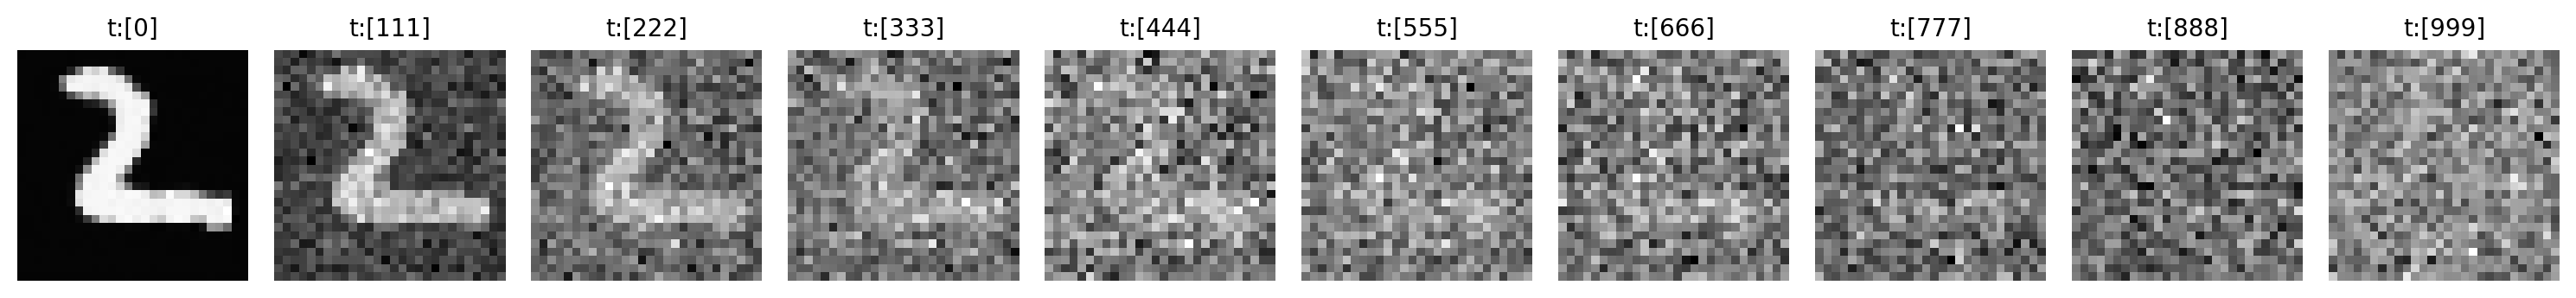

Done.


In [4]:
# Instantiate U-net
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 2,
    n_in_channels        = 1,
    n_base_channels      = 64,
    n_emb_dim            = 128,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False, # no attention for images
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,1,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x W x H] => output:[B x C x W x H]

# Configuration
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x W x H]
    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x W x H]
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)

print ("Done.")

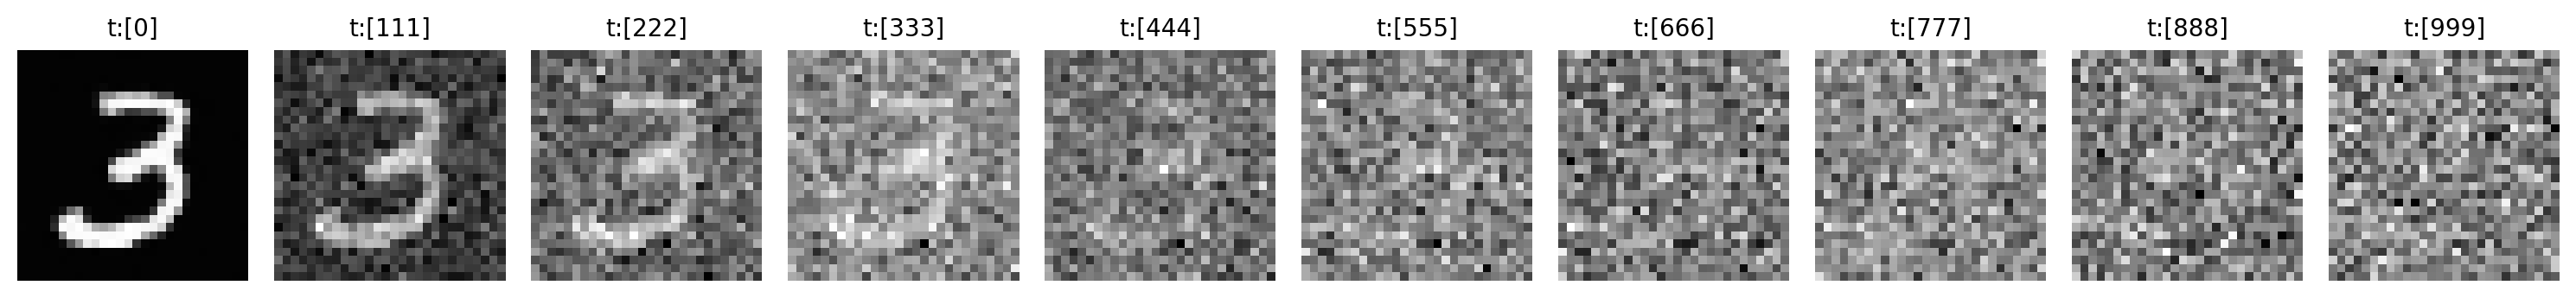

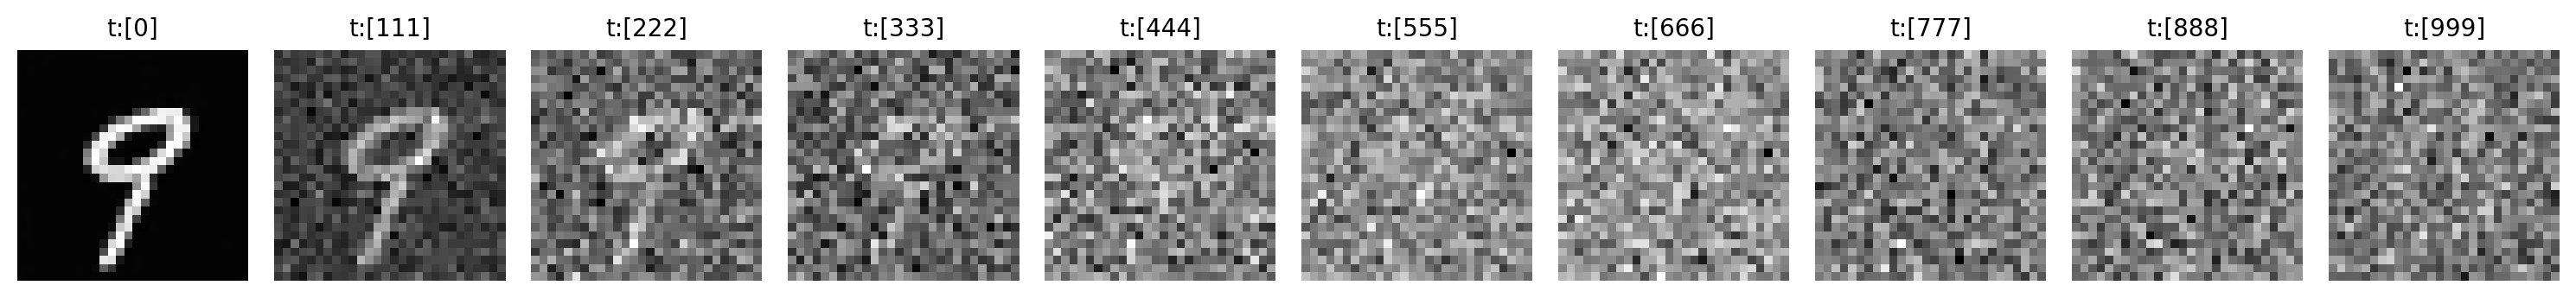

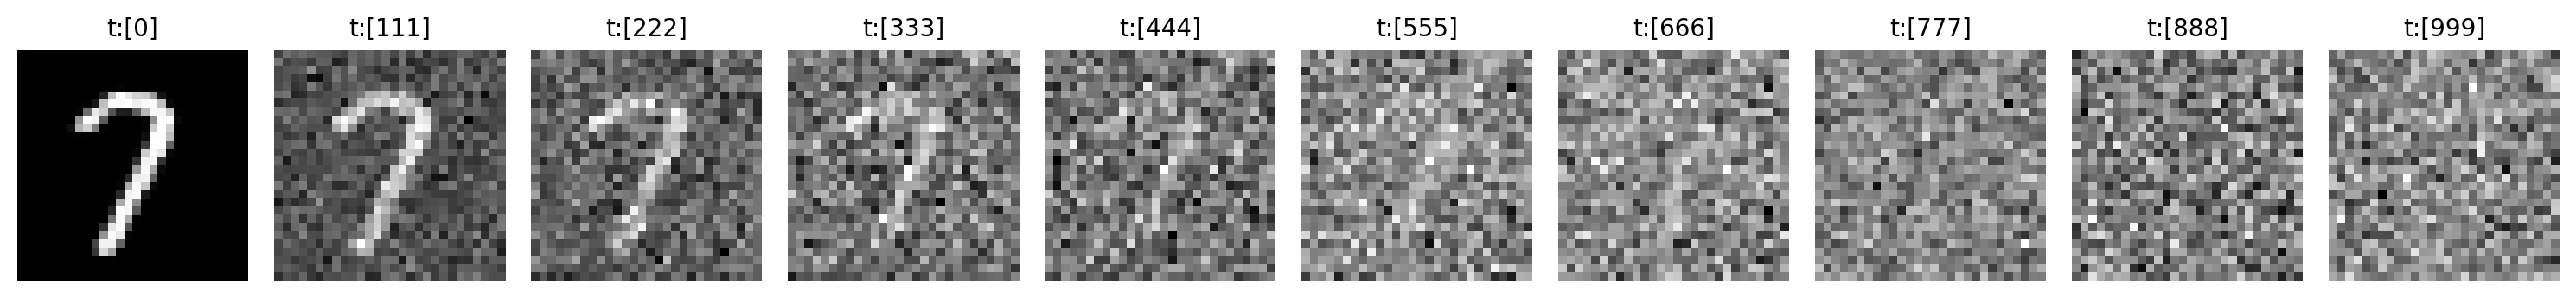

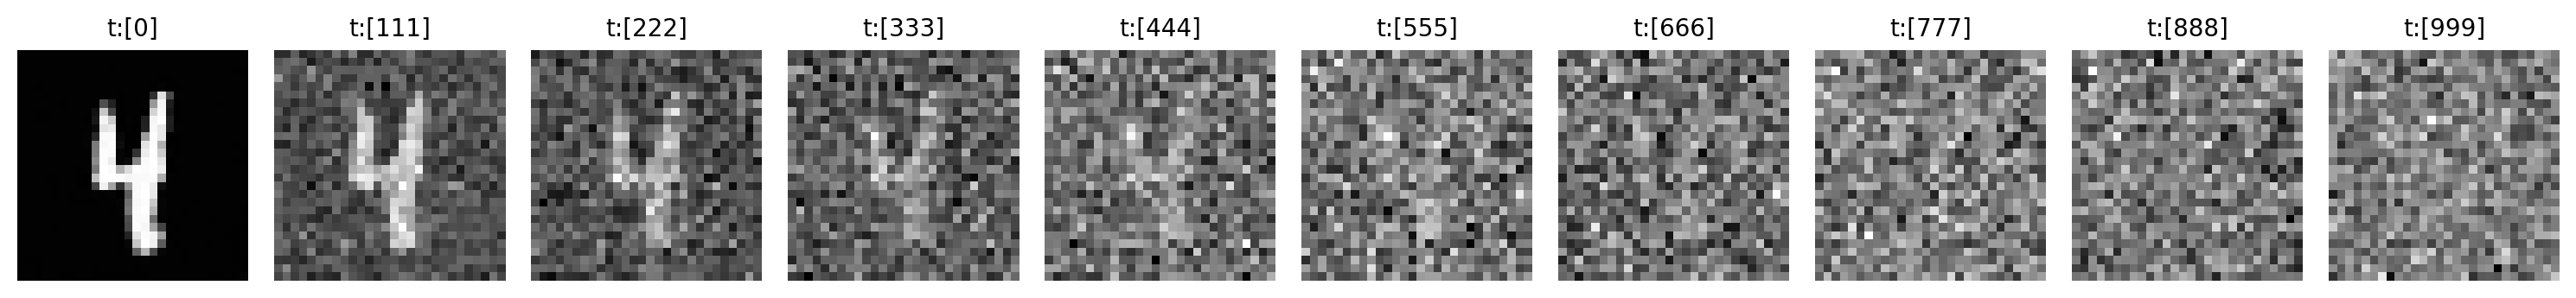

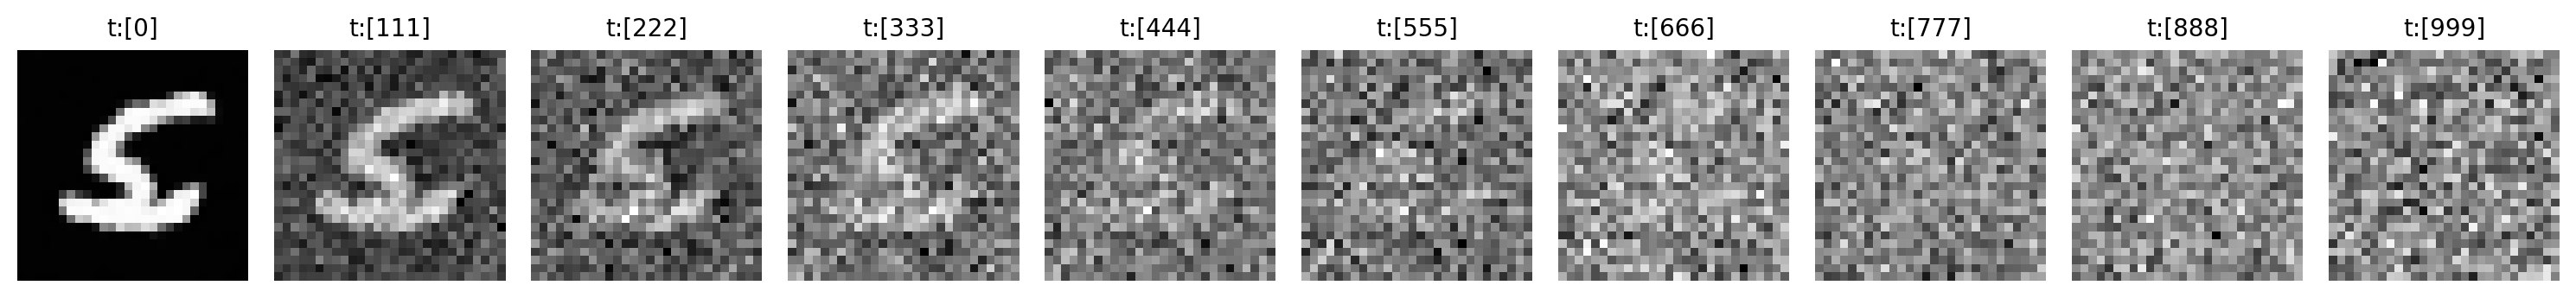

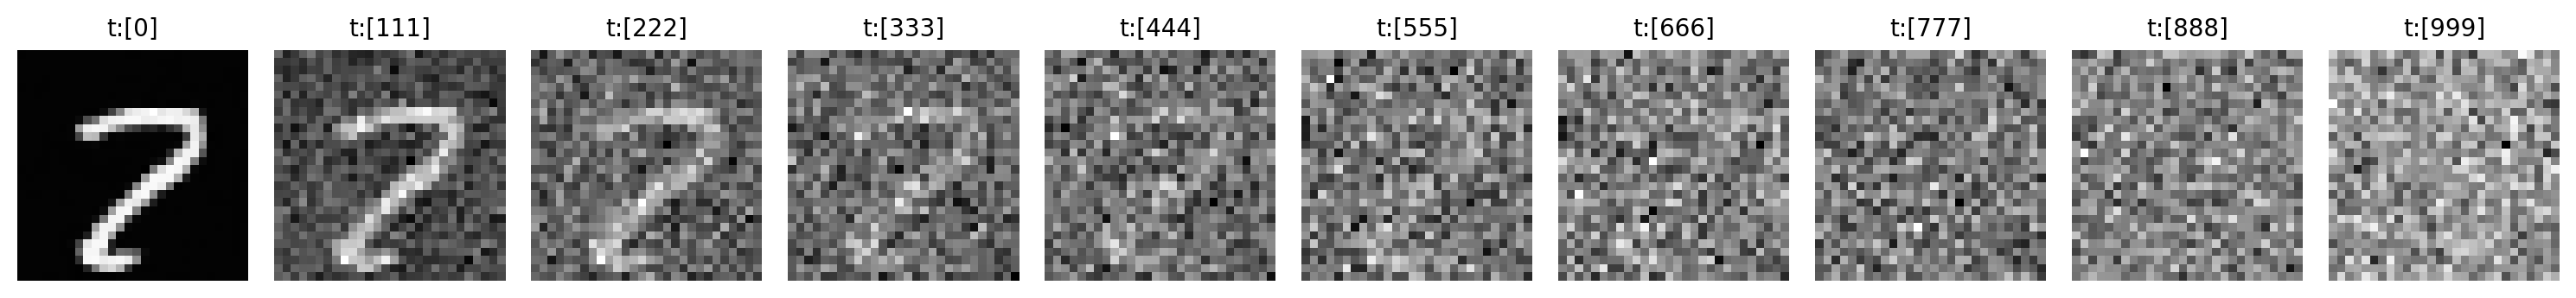

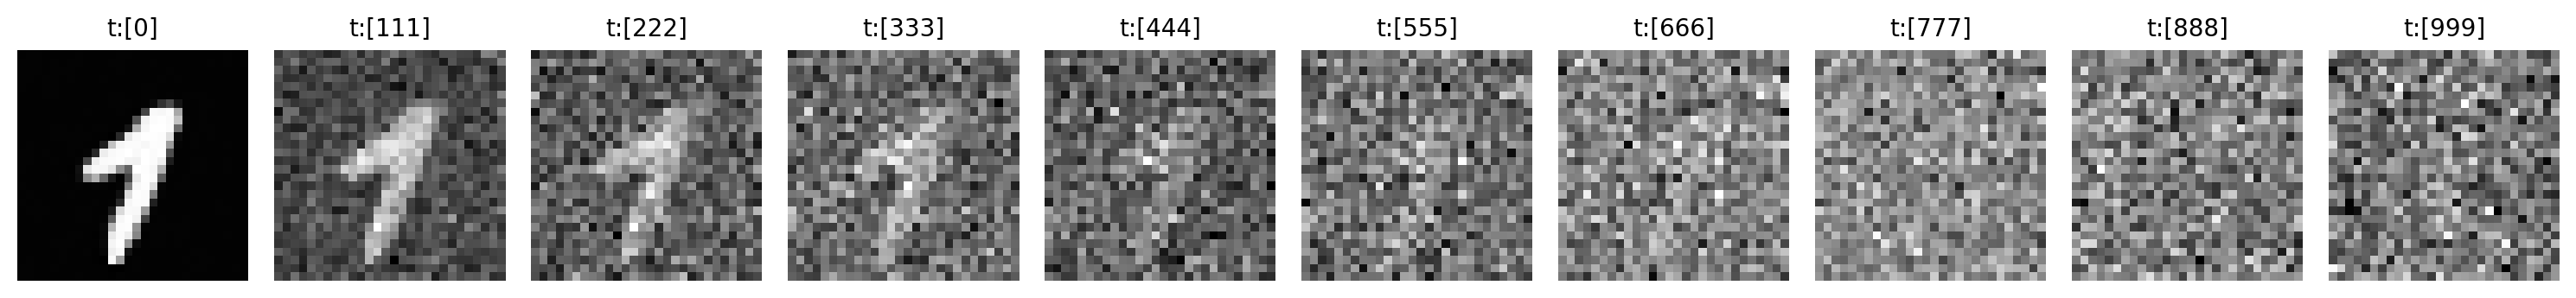

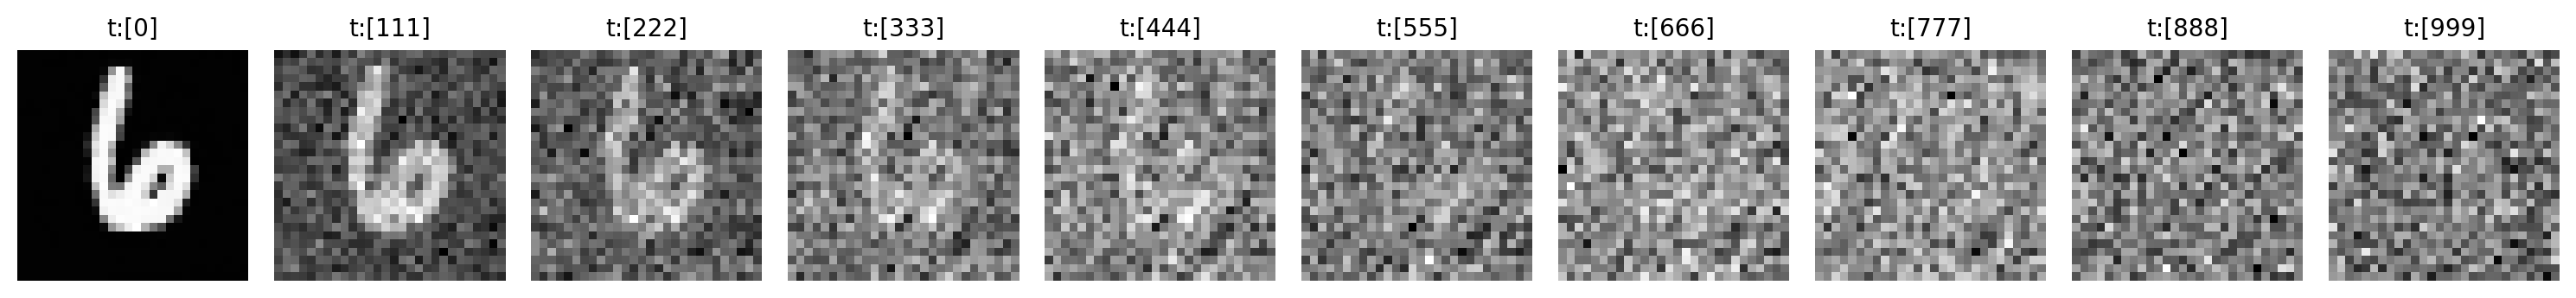

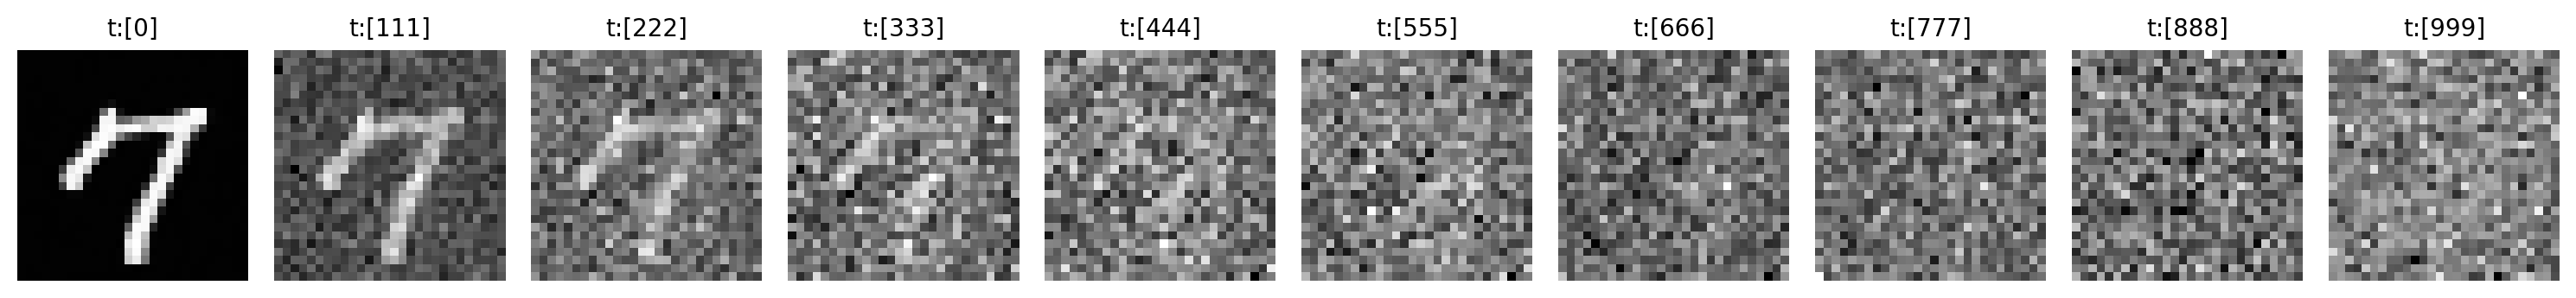

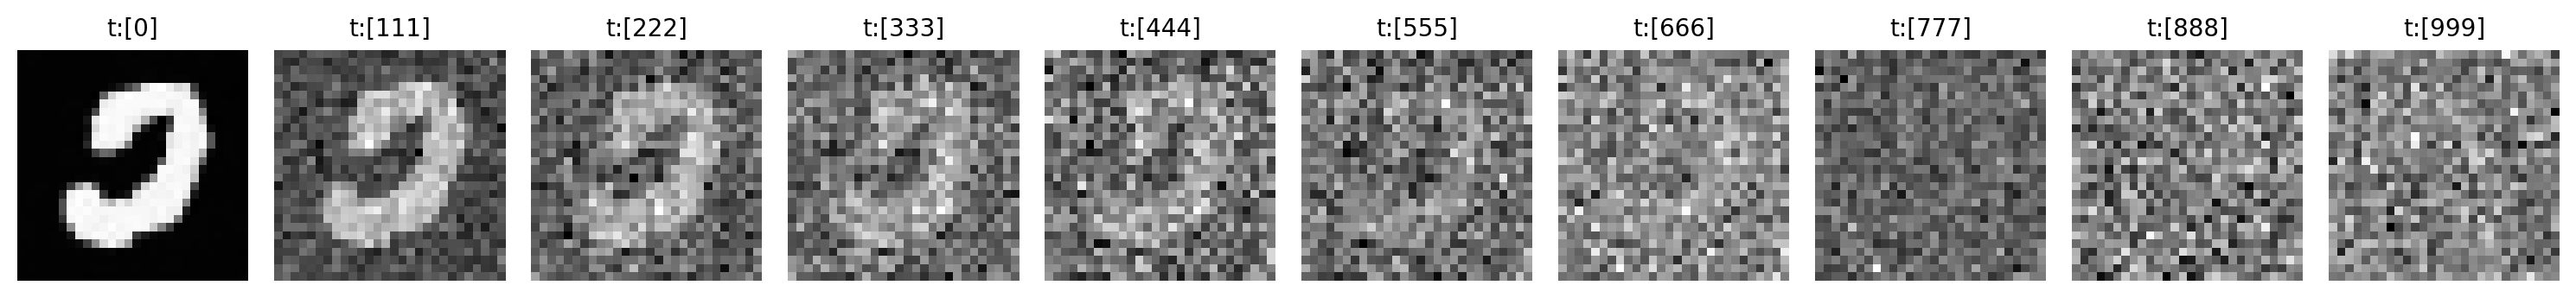

In [5]:
n_sample = 10
step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device)
plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)